In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from ordered_set import OrderedSet

import warnings
warnings.filterwarnings('ignore')

### Introduction

1. We will implement PageRank algorithm on knowledge graph built on ML1M dataset. 
2. We will directly read the gpickle file that we saved in the notebook named [ml1m_kg_networkx](https://github.com/rajatguptakgp/practical_machine_learning/blob/main/ml1m_kg_networkx.ipynb)
3. We will consider the PageRank scores for movies to rank them for generating predictions for users. Note that the predictions here are same for all users based on decreasing movie pagerank score and so we do not expect recommendation metrics to be good, but we can also calculate something called as **Personalized PageRank (PPR)** for each user that highlights their preference for different movies. Also, no rating has been considered for predictions.

In [2]:
# config
alpha = 0.8
n_iter = 1000
seed = 42
graph_path = 'ml1m.gpickle'

In [3]:
def make_pagerank_matrix(G, alpha):
    n_nodes = len(G.nodes())

    # building adjacent matrix
    adj_matrix = np.zeros(shape=(n_nodes, n_nodes))
    for edge in G.edges():
        adj_matrix[edge[0], edge[1]] = 1

    # building transition probability matrix
    tran_matrix = adj_matrix / np.sum(adj_matrix, axis=1).reshape(-1,1)
    tran_matrix = np.nan_to_num(tran_matrix)
    
    # building random surfer matrix
    random_surf = np.ones(shape = (n_nodes, n_nodes)) / n_nodes    

    # building transition matrix for absorbing nodes
    absorbing_nodes = np.zeros(shape = (n_nodes,))
    for node in G.nodes():
        if len(G.successors(node))==0:
            absorbing_nodes[node] = 1
    absorbing_node_matrix = np.outer(absorbing_nodes, np.ones(shape = (n_nodes,))) / n_nodes

    # stochastic matrix
    stochastic_matrix = tran_matrix + absorbing_node_matrix

    # pagerank matrix
    pagerank_matrix = alpha * stochastic_matrix + (1-alpha) * random_surf
    return pagerank_matrix

In [4]:
def random_walk(G, alpha, n_iter):
    n_nodes = len(G.nodes())
    initial_state = np.ones(shape=(n_nodes,)) / n_nodes
    pagerank_matrix = make_pagerank_matrix(G, alpha)

    new_initial_state = initial_state
    print('Running random walk..')
    NORM = []
    for i in tqdm(range(n_iter)):
        final_state = np.dot(np.transpose(pagerank_matrix), new_initial_state)
        
        prev_initial_state = new_initial_state
        new_initial_state = final_state
        L2 = np.linalg.norm(new_initial_state-prev_initial_state)
        NORM.append(L2)
        if np.allclose(new_initial_state, prev_initial_state):
            print(f'Converged at {i+1} iterations..')
            break

    plt.figure(figsize=(5,4))
    plt.plot(range(i+1), NORM)
    plt.xlabel('iterations')
    plt.ylabel('Euclidean Norm')
    plt.title('Convergence plot')
    plt.show()
    return final_state

In [5]:
def run(G, alpha, n_iter):
    final_probs = random_walk(G, alpha, n_iter)

    # ensuring pagerank importance for each node
    assert len(final_probs) == len(G.nodes())

    # ensuring probabilities sum to 1
    assert np.allclose(np.sum(final_probs), 1)

    return final_probs

Number of nodes:  9940
Number of edges:  1511854

Relabelling nodes to integers..
Running random walk..


  5%|▍         | 46/1000 [00:03<01:04, 14.84it/s]


Converged at 47 iterations..


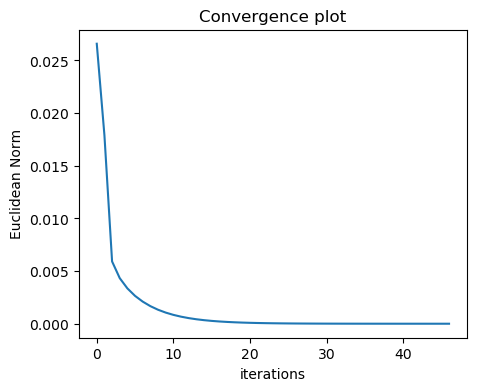

In [6]:
# loading networkx graph
G = nx.read_gpickle(graph_path)

print('Number of nodes: ', len(G.nodes()))
print('Number of edges: ', len(G.edges()))

print()
print('Relabelling nodes to integers..')
n_unique_nodes = len(set(G.nodes()))
node2int = dict(zip(set(G.nodes()), range(n_unique_nodes)))
int2node = {v:k for k,v in node2int.items()}
# input for pagerank
G = nx.relabel_nodes(G, node2int)
final_probs = run(G, alpha, n_iter)

# back to original nodes
G = nx.relabel_nodes(G, int2node)
pagerank_scores_dict = dict(zip(G.nodes(), final_probs))

In [7]:
with open('ml-1m/movies.dat','r', encoding="ISO-8859-1") as f:
    data = f.read().splitlines()

data = list(map(lambda x: x.split('::'), data))
movies_df = pd.DataFrame(data, columns = ['movieID','title','genres'])
movies_df['movieID'] = movies_df['movieID'].astype('int')
movieID2name = dict(zip(movies_df['movieID'].values, movies_df['title'].values))

In [8]:
with open('ml-1m/ratings.dat','r', encoding="ISO-8859-1") as f:
    data = f.read().splitlines()

data = list(map(lambda x: x.split('::'), data))
ratings_df = pd.DataFrame(data, columns = ['userID','movieID','rating','timestamp'])
ratings_df[['userID','movieID','rating']] = ratings_df[['userID','movieID','rating']].astype('int')

In [9]:
# splitting data into training and validation split for recommendation
# using same split (seed) which was used in creating the knowledge graph
ratings_df, ratings_val = train_test_split(ratings_df, test_size=0.1, random_state=42)
ratings_df.shape, ratings_val.shape

((900188, 4), (100021, 4))

In [10]:
ranking = []
for node, score in pagerank_scores_dict.items():
    if isinstance(node, int) and node>0:
        ranking.append([node, score])

# sorting movies in decreasing order of pagerank scores
# this list serves as top movie recommendations for any user
sorted_movies = np.array(sorted(ranking, key=lambda x:x[1], reverse=True)).astype('int')[:, 0].tolist()

print('Top 5 rated movies based on pagerank scores..')
list(map(lambda x: movieID2name[x], sorted_movies))[:5]

Top 5 rated movies based on pagerank scores..


['Simon Birch (1998)',
 'In the Company of Men (1997)',
 "Schindler's List (1993)",
 'Big (1988)',
 "Puppet Master III: Toulon's Revenge (1991)"]

In [11]:
def get_predictions(ratings_df, ratings_val, sorted_movies):
    """ 
    for users predictions will be made for movies 
    which they have not rated from training set
    """
    
    # check for users present in validation and training set
    commonIDs = set(ratings_val['userID']) and set(ratings_df['userID'])
    uncommonIDs = set(ratings_val['userID']) - set(ratings_df['userID'])

    rated_movies_dict = dict(ratings_df.groupby('userID')['movieID'].apply(lambda x: set(x)))
    
    # sorted set for movies
    sorted_movies_set = OrderedSet(sorted_movies)
    pred = dict(zip(commonIDs, map(lambda x: list(sorted_movies_set - rated_movies_dict[x]), commonIDs)))
    if uncommonIDs:
        pred2 = {}
        pred2 = dict(zip(uncommonIDs, [sorted_movies]*len(uncommonIDs)))
        pred.update(pred2)
    return pred

In [12]:
def get_eval_data(ratings_val):
    gt = {}
    pred = {}
    ratings_val = ratings_val.reset_index(drop=True)

    # getting ground truth data
    for idx in range(len(ratings_val)):
        userID = ratings_val.loc[idx, 'userID']
        movieID = ratings_val.loc[idx, 'movieID']
        rating = ratings_val.loc[idx, 'rating']
        if gt.get(userID):
            gt[userID].append([movieID, rating])
        else:
            gt[userID] = [[movieID, rating]]

    # sorting movies according to ratings
    for k, v in gt.items():
        gt[k] = np.array(sorted(gt[k], key = lambda x: x[1], reverse=True)).astype('int')[:, 0].tolist()    

    # getting predictions based on pagerank scores
    pred = get_predictions(ratings_df, ratings_val, sorted_movies)            
    return gt, pred

#### Order unaware metrics:
1. Hit@K
2. Precision@K
3. Recall@K
4. F1@K

#### Order aware metrics:
1. MRR@K

For more information: [Recommendation Evaluation Metrics](https://github.com/rajatguptakgp/ml_from_scratch/blob/master/recommendation_evaluation_metrics.ipynb)

In [13]:
def hit_k(act, pred, k):
    act_set = set(act)
    pred_set = set(pred[:k])   
    common_set = act_set & pred_set   
    if (len(common_set)>0):
        return 1
    else:
        return 0
    
def precision_k(act, pred, k):
    act_set = set(act)
    pred_set = set(pred[:k])    
    common_set = act_set & pred_set   
    if len(pred_set)==0:
        return 0
    else:
        return len(common_set) / len(pred_set)

def recall_k(act, pred, k):
    act_set = set(act)
    pred_set = set(pred[:k])   
    common_set = act_set & pred_set
    if len(act_set)==0:
        return 0
    else:
        return len(common_set) / len(act_set)

def mean_reciprocal_rank_k(act, pred, k):
    found = 0
    for i in range(len(pred)):
        if pred[i] in act[:k]:
            found = 1
            break
    if found:
        mrr = 1 / (i+1)
    else:
        mrr = 0
    return mrr

# overall MRR
def mean_reciprocal_rank(gt, predictions):
    def find_reciprocal_rank(act, pred):
        pred = np.array(pred)
        for p in pred:
            if p in act:
                rank = np.where(pred==p)[0][0] + 1
                return 1/rank
        return 0
    return np.mean(list(map(lambda x, y: find_reciprocal_rank(x, y), gt, predictions)))    

In [14]:
def calculate_scores(metric):    
    values_normalized = []
    for v in metric.values():
        values_normalized.append(v[0]/max(v[1],1))
    return values_normalized
    
def get_recommendation_metrics(gt, pred):
    hit = {}
    rec = {}
    prec = {}
    mrr = {}

    topK = [5, 10, 20, 50, 100, 200]
    for i in topK:
        hit[i] = [0, 0]
        rec[i] = [0, 0]
        prec[i] = [0, 0]
        mrr[i] = [0, 0]

    for user in gt.keys():
        for topk in rec.keys():
            # if number of predictions are less than topK, skip 
            if len(pred[user])<topk:
                break

            h = hit_k(gt[user], pred[user], topk)
            r = recall_k(gt[user], pred[user], topk)
            p = precision_k(gt[user], pred[user], topk)
            m = mean_reciprocal_rank_k(gt[user], pred[user], topk)

            hit[topk] = [hit[topk][0]+h, hit[topk][1]+1]
            rec[topk] = [rec[topk][0]+r, rec[topk][1]+1]
            prec[topk] = [prec[topk][0]+p, prec[topk][1]+1]
            mrr[topk] = [mrr[topk][0]+m, mrr[topk][1]+1]

    labels=['Precision@K','Recall@K','Hit@K','MRR@K']
    metrics=[prec,rec,hit,mrr]
    df_scores = pd.DataFrame(index=topK, columns=['Precision@K','Recall@K','F1@K','Hit@K','MRR@K'])
    for label, metric in zip(labels, metrics):
        scores = calculate_scores(metric)
        df_scores[label]=scores
    df_scores['F1@K']=(2 * df_scores['Recall@K'] * df_scores['Precision@K'])/(df_scores['Recall@K'] + df_scores['Precision@K'])
    df_scores = df_scores.reset_index()
    df_scores.rename(columns={'index':'K'}, inplace=True)
    return df_scores

In [15]:
def return_plot(df_scores,label):
    X=df_scores.K
    Y=df_scores[label].values
    
    plt.title(f'{label}')
    plt.xlabel('K')
    plt.ylabel('Values')
    plt.xticks(X)
    plt.plot(X,Y,c='k',linestyle='--',marker='o')
    return plt

def plotting(df_scores):
    fig=plt.figure(figsize=(17, 5), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(131)
    plt1 = return_plot(df_scores,'Precision@K')
    plt.subplot(132)
    plt2 = return_plot(df_scores,'Recall@K')
    plt.subplot(133)
    plt3 = return_plot(df_scores,'F1@K')
    plt.show()

    fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    plt4 = return_plot(df_scores,'Hit@K')
    plt.subplot(122)
    plt5 = return_plot(df_scores,'MRR@K')
    plt.show()

Getting evaluation data..

Recommendation metrics..
     K  Precision@K  Recall@K      F1@K     Hit@K     MRR@K
0    5     0.014171  0.004706  0.007065  0.066499  0.017496
1   10     0.012663  0.008393  0.010095  0.110385  0.024728
2   20     0.008258  0.010210  0.009131  0.136516  0.031672
3   50     0.007384  0.021559  0.011000  0.260637  0.038010
4  100     0.005635  0.032554  0.009607  0.343049  0.039013
5  200     0.005004  0.058533  0.009220  0.485260  0.039220 

Overall MRR:  0.030300381130132045


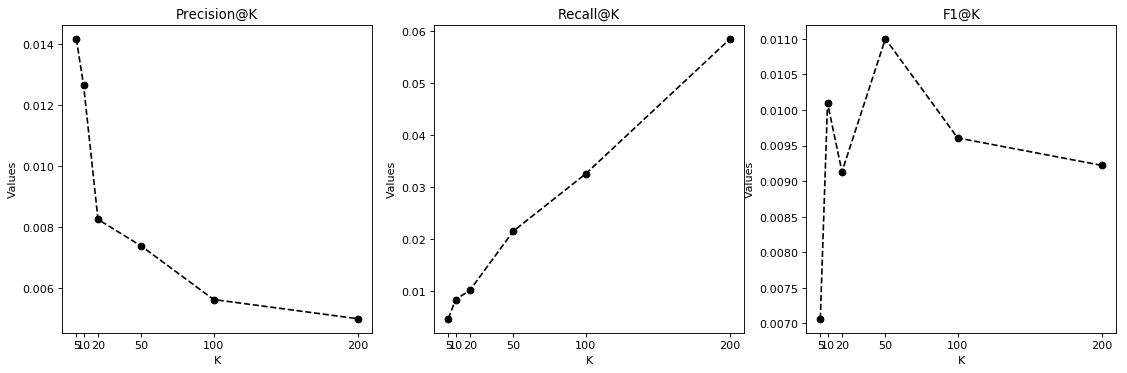

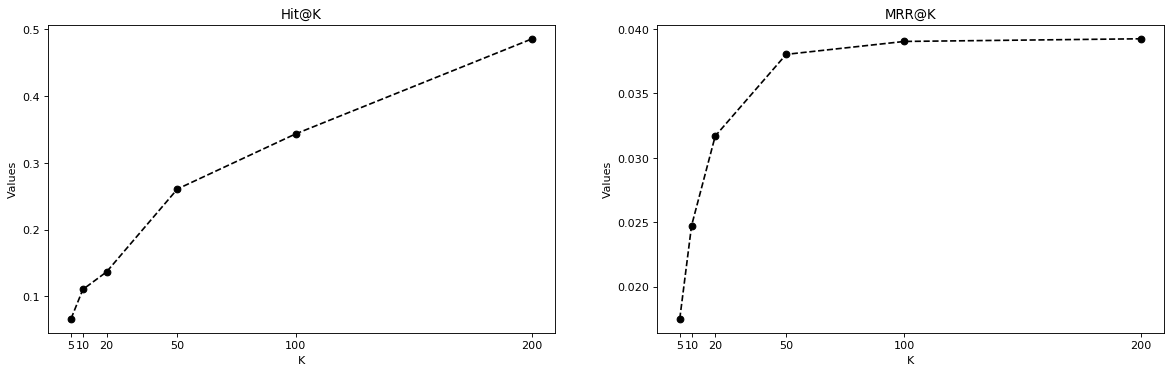

In [16]:
# getting ground truth and predictions for validation set
print('Getting evaluation data..\n')
gt, pred = get_eval_data(ratings_val)

# generating evaluation metrics
df_scores = get_recommendation_metrics(gt, pred)
print('Recommendation metrics..')
print(df_scores,'\n')

# getting overall MRR
user_rated_movies = list(gt.values())
predictions = list(pred.values())
print('Overall MRR: ', mean_reciprocal_rank(user_rated_movies, predictions))

# plotting metrics
plotting(df_scores)

### Final Notes: 

The scores do not look great because we have assumed that the recommendations for every user are similar. Instead, we should look at Personalized PageRank (PPR) score that generates a recommendation set of movies for every user based on their behavior.